In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE, r2_score as R2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator
from typing import Union, Tuple
from xgboost import XGBRegressor
from pprint import pprint
from datetime import datetime
from joblib import dump

In [2]:
processed_folder = Path.cwd().parent / 'data' / 'processed' 
plt.style.use('ggplot')

In [3]:
df = pd.read_parquet(processed_folder / 'df_model_tidy.parquet')
df.head()

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
3,2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
4,2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041


# Modelo XGboost

In [4]:
#separacion en train y test
X = df.iloc[:, :-1].drop(columns = 'date')
y = df.presion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Busqueda de parametros y entrenamiento

In [5]:

# definimos la función que toma datos y devuelve los mejores parámetros

def search_params(
        estimator: BaseEstimator,
        params: dict,
        X: np.ndarray, 
        y: np.ndarray, 
        random: bool = False, 
        n_iter: int = 100,
    ) -> Tuple[XGBRegressor, dict]:
    # Definir los parámetros para GridSearchCV

    print(f"Los parámetros para probar en nuestras pipelines son:")
    pprint(params)

    # Creamos un pipeline con parámetros por defecto (serán sustituidos)
    pipeline = Pipeline([
        ('scaler', None),
        ('regressor', estimator())
    ])

    if random:
        search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, 
                                    scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
    else:
        search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, 
                              scoring='neg_mean_squared_error', verbose=1)

    search.fit(X, y)

    # Obtener los mejores hiperparámetros y el mejor modelo
    best_params = search.best_params_
    best_model = search.best_estimator_

    print(f"Los mejores parámetros de la busqueda: {best_params}")
    print(f"El mejor modelo de la busqueda: {best_model}")

    return best_model, best_params

In [6]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.3, 0.5, 0.7],
    'regressor__reg_lambda':[1, 10, 100],
    'regressor__colsample_bytree': [0.5, 0.7]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
best_model, best_params = search_params(XGBRegressor, 
                                        xgb_params, 
                                        X_train, 
                                        y_train, 
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Los parámetros para probar en nuestras pipelines son:
{'regressor__colsample_bytree': [0.5, 0.7],
 'regressor__learning_rate': [0.01, 0.1, 0.2],
 'regressor__max_depth': [3, 4, 5],
 'regressor__n_estimators': [50, 100, 200],
 'regressor__reg_lambda': [1, 10, 100],
 'regressor__subsample': [0.3, 0.5, 0.7]}
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Los mejores parámetros de la busqueda: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.7}
El mejor modelo de la busqueda: Pipeline(steps=[('scaler', None),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7, device=None,
                              early_stopping_rounds=None,
                              e

## Evaluación modelo

In [7]:
#predicciones para test y para train
y_test_hat = best_model.predict(X_test)
y_train_hat = best_model.predict(X_train)

<Axes: title={'center': 'test data'}, ylabel='presion'>

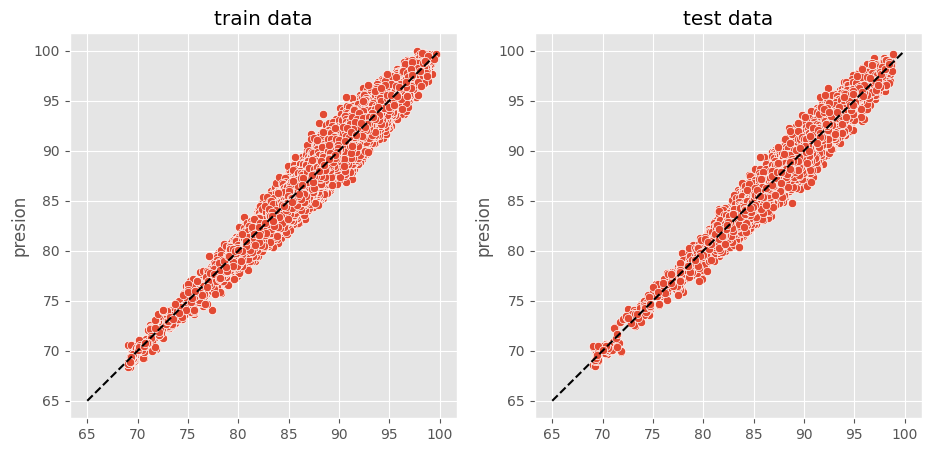

In [24]:
#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 2, figsize = (11, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_train_hat, 
                y = y_train,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])

axs[1].set_title('test data')
sns.scatterplot(x = y_test_hat, 
                y = y_test,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])

In [9]:
mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")

error medio absoluto en train 0.58
error medio absoluto en test 0.59


In [10]:
df['presion_hat'] = np.nan

In [11]:
X_train.index

Index([204020, 229382,  19325, 243547, 236718, 114238, 168820, 145647, 104839,
        75619,
       ...
        53358,  64768, 197548, 166122, 240127,  10891,  71865,  67122, 203040,
       187840],
      dtype='int64', length=198938)

In [12]:
df.loc[X_train.index].shape

(198938, 15)

In [13]:
df.loc[X_train.index, 'presion_hat'] = y_train_hat
df.loc[X_test.index, 'presion_hat'] = y_test_hat

## Visto desde la serie de tiempo

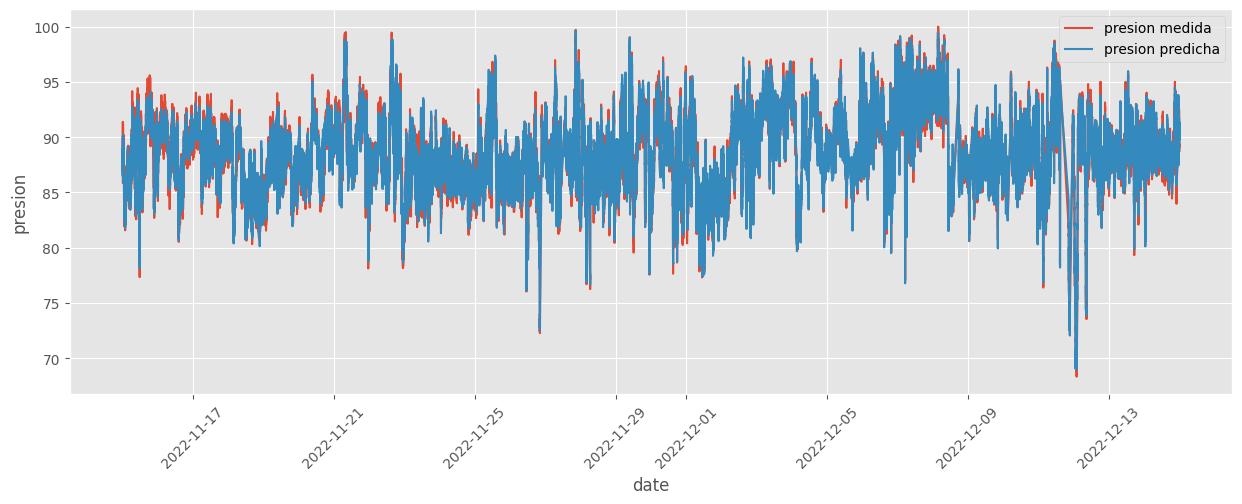

In [14]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)


## Feature importance

In [20]:
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_train.columns

Text(0.5, 1.0, 'Feature Importance of XGBoost Model')

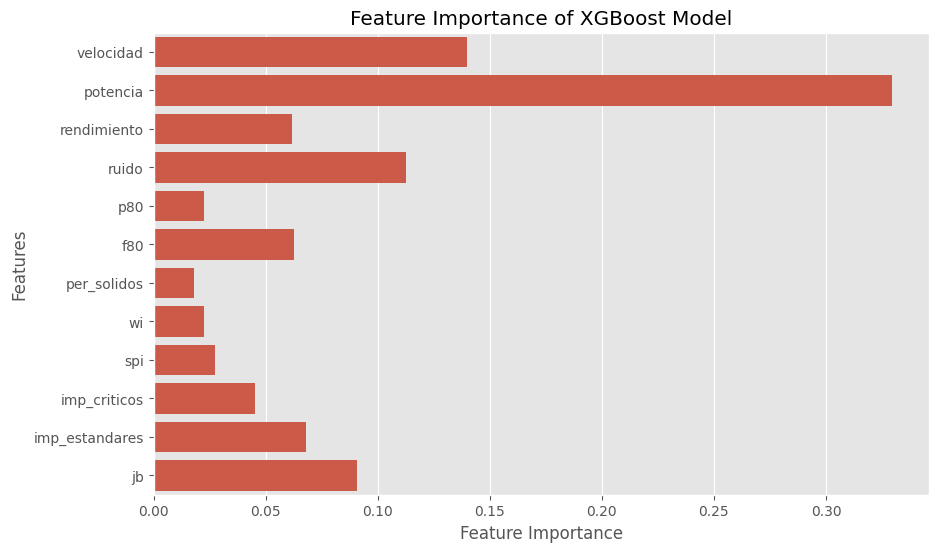

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, ax=ax)


ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance of XGBoost Model')

In [ ]:
#guardar modelo
dump(model, './../xgboost_model.joblib')


# Bajando número de variables

In [ ]:
En esta parte se intanta trabajar con variables que pueden ser controladas de manera más directa

<Axes: xlabel='velocidad', ylabel='Count'>

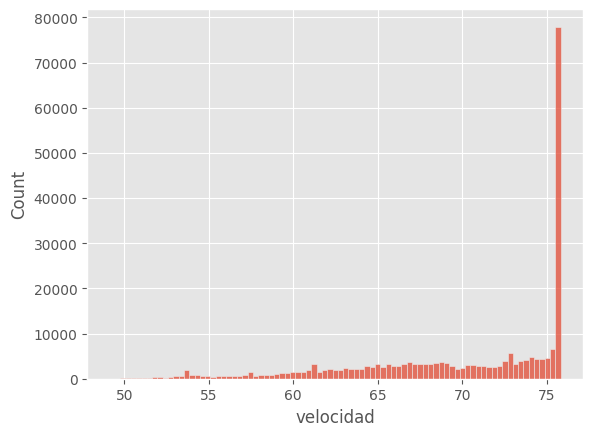

In [36]:
#La mayor parte de los datos se encuentran en rangos operaciones, nos centramos en velocidades por encima del 70% 
sns.histplot(df.velocidad)

In [37]:
df.date

0        2022-11-15 00:07:50
1        2022-11-15 00:08:00
2        2022-11-15 00:08:10
3        2022-11-15 00:08:20
4        2022-11-15 00:08:30
                 ...        
248668   2022-12-14 23:59:20
248669   2022-12-14 23:59:30
248670   2022-12-14 23:59:40
248671   2022-12-14 23:59:50
248672   2022-12-15 00:00:00
Name: date, Length: 248673, dtype: datetime64[us]

In [42]:
vars_2 = ['p80', 'f80', 'per_solidos', 'wi', 'potencia', 'jb', 'presion']
df2 = df[df.velocidad > 70][vars_2]

X = df2[vars_2[:-1]]

y = df2.presion

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
best_model, best_params = search_params(XGBRegressor, 
                                        xgb_params, 
                                        X_train, 
                                        y_train, 
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Los parámetros para probar en nuestras pipelines son:
{'regressor__colsample_bytree': [0.8, 1.0],
 'regressor__learning_rate': [0.01, 0.1, 0.2],
 'regressor__max_depth': [3, 4, 5],
 'regressor__n_estimators': [50, 100, 200],
 'regressor__subsample': [0.8, 1.0]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Los mejores parámetros de la busqueda: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
El mejor modelo de la busqueda: Pipeline(steps=[('scaler', None),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              f

In [46]:
y_test_hat = best_model.predict(X_test)
y_train_hat = best_model.predict(X_train)

mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")

error medio absoluto en train 0.66
error medio absoluto en test 0.67


In [47]:
R2_t1_train = R2(y_train, y_train_hat)
R2_t1_test = R2(y_test, y_test_hat)

print(f"R2 en train {R2_t1_train:.2f}")
print(f"R2 en test {R2_t1_test:.2f}")

R2 en train 0.93
R2 en test 0.93


In [48]:
df2['presion_hat'] = np.nan
df2.loc[X_train.index, 'presion_hat'] = y_train_hat
df2.loc[X_test.index, 'presion_hat'] = y_test_hat

<Axes: ylabel='presion'>

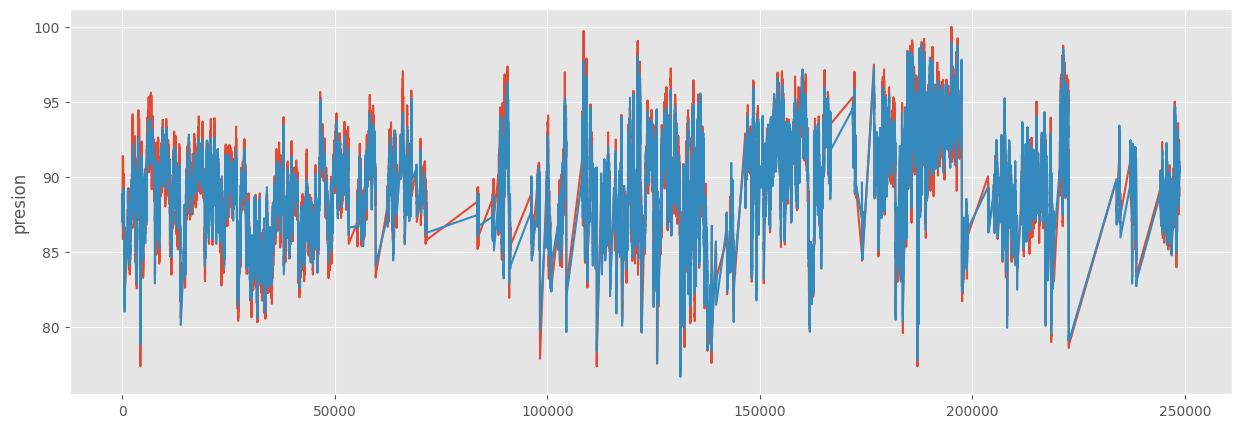

In [49]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.lineplot(df2.presion)
sns.lineplot(df2.presion_hat)

In [22]:
y_new_hat = best_model.predict(X_new.drop(columns = ['date', 'presion']))

In [23]:
X_new['presion_hat'] = y_new_hat

/tmp/ipykernel_4534/3793611637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['presion_hat'] = y_new_hat


<Axes: ylabel='presion'>

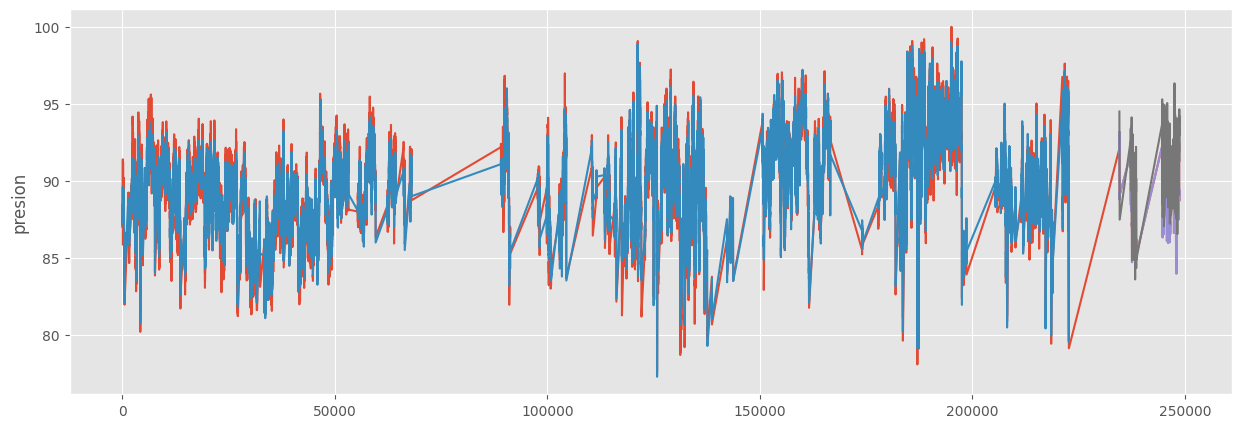

In [24]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.lineplot(df2.presion)
sns.lineplot(df2.presion_hat)

sns.lineplot(X_new.presion)
sns.lineplot(X_new.presion_hat)

<Axes: ylabel='presion'>

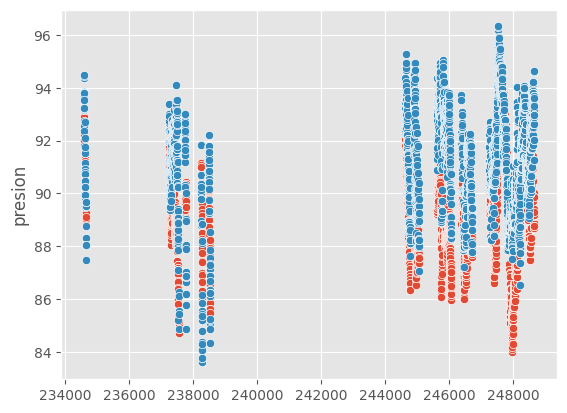

In [25]:
sns.scatterplot(X_new.presion)
sns.scatterplot(X_new.presion_hat)

<Axes: xlabel='presion_hat', ylabel='presion'>

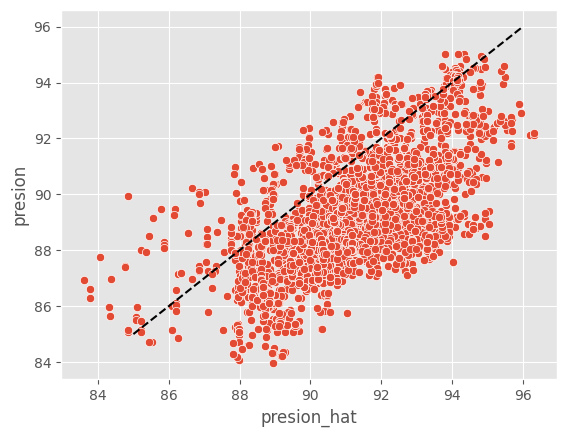

In [27]:
sns.scatterplot(x = 'presion_hat',
             y = 'presion',
            data = X_new)

sns.lineplot(x = [85, 96],
             y = [85, 96],
             color = 'black',
             linestyle = '--')